In [2]:
import sys
sys.path.append("../") # adding the path to read the utils file
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn import metrics, tree
from shap import plots, Explanation
import fasttreeshap
import time
import shap
from tqdm import tqdm
from matplotlib import ticker
import pickle
import lightgbm as lgb
from utils import *
import graphviz
from yellowbrick.model_selection import LearningCurve

pd.set_option('display.max_columns', None)

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)
IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


In [3]:
# you should run making_hikari2022_csv.ipynb before running this cell, since the two csv given with the paper have two differences
# to see what are the data types and the features of the dataset, you can take a look on the utils file
ds = pd.concat([
    pd.read_csv('../datasets/HIKARI-2021/ALLFLOWMETER_HIKARI2021.csv', dtype=dtype_hikari, usecols=selected_features_hikari),
    pd.read_csv('../datasets/HIKARI-2021/ALLFLOWMETER_HIKARI2022.csv', dtype=dtype_hikari, usecols=selected_features_hikari)], 
    ignore_index=True)
ds.head()

,flow_duration,fwd_pkts_tot,bwd_pkts_tot,fwd_data_pkts_tot,bwd_data_pkts_tot,fwd_pkts_per_sec,bwd_pkts_per_sec,flow_pkts_per_sec,down_up_ratio,fwd_header_size_tot,fwd_header_size_min,fwd_header_size_max,bwd_header_size_tot,bwd_header_size_min,bwd_header_size_max,flow_FIN_flag_count,flow_SYN_flag_count,flow_RST_flag_count,fwd_PSH_flag_count,bwd_PSH_flag_count,flow_ACK_flag_count,fwd_URG_flag_count,bwd_URG_flag_count,flow_CWR_flag_count,flow_ECE_flag_count,fwd_pkts_payload.min,fwd_pkts_payload.max,fwd_pkts_payload.tot,fwd_pkts_payload.avg,fwd_pkts_payload.std,bwd_pkts_payload.min,bwd_pkts_payload.max,bwd_pkts_payload.tot,bwd_pkts_payload.avg,bwd_pkts_payload.std,flow_pkts_payload.min,flow_pkts_payload.max,flow_pkts_payload.tot,flow_pkts_payload.avg,flow_pkts_payload.std,fwd_iat.min,fwd_iat.max,fwd_iat.tot,fwd_iat.avg,fwd_iat.std,bwd_iat.min,bwd_iat.max,bwd_iat.tot,bwd_iat.avg,bwd_iat.std,flow_iat.min,flow_iat.max,flow_iat.tot,flow_iat.avg,flow_iat.std,payload_bytes_per_second,fwd_subflow_pkts,bwd_subflow_pkts,fwd_subflow_bytes,bwd_subflow_bytes,fwd_bulk_bytes,bwd_bulk_bytes,fwd_bulk_packets,bwd_bulk_packets,fwd_bulk_rate,bwd_bulk_rate,active.min,active.max,active.tot,active.avg,active.std,idle.min,idle.max,idle.tot,idle.avg,idle.std,fwd_init_window_size,bwd_init_window_size,fwd_last_window_size,traffic_category,Label
0,2.207588,15,14,6,6,6.794746,6.341763,13.136509,0.933333,464,20,40,492,32,44,2,2,2,6,5,26,0,0,0,0,0,742,1826.0,121.733333,220.736581,0,1448,5025.0,358.928571,552.239840,0,1448,6851.0,236.241379,424.859275,18.119812,1.963762e+06,2.207603e+06,1.576859e+05,5.205052e+05,7.867813,2.032929e+06,2.177950e+06,1.675346e+05,5.606267e+05,7.867813,1.963762e+06,2.207603e+06,78842.963491,3.696378e+05,3103.387105,7.5,7.0,913.0,2512.5,0.0,0.0,0.0,0.0,0.0,0.0,2.207603e+06,2.207603e+06,2.207603e+06,2.207603e+06,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,29200,65160,0,Bruteforce-XML,True
1,15.624266,15,14,6,6,0.960045,0.896042,1.856087,0.933333,488,20,44,468,32,44,2,2,2,6,5,26,0,0,0,0,0,745,1829.0,121.933333,221.339257,0,1448,5025.0,358.928571,552.239840,0,1448,6854.0,236.344828,424.987166,20.980835,1.534300e+07,1.562428e+07,1.116020e+06,4.094889e+06,20.980835,1.541144e+07,1.559517e+07,1.199628e+06,4.270148e+06,10.013580,1.534300e+07,1.562428e+07,558009.896960,2.897622e+06,438.676603,7.5,7.0,914.5,2512.5,0.0,0.0,0.0,0.0,0.0,0.0,2.883792e+04,2.524381e+05,2.812760e+05,1.406380e+05,158109.181742,1.534300e+07,1.534300e+07,1.534300e+07,1.534300e+07,0.0,29200,65160,0,Bruteforce-XML,True
2,12.203357,14,13,6,5,1.147225,1.065281,2.212506,0.928571,432,20,40,448,32,44,2,2,2,6,5,24,0,0,0,0,0,744,1828.0,130.571429,226.803444,0,2896,5025.0,386.538462,817.479013,0,2896,6853.0,253.814815,592.570284,36.001205,1.196814e+07,1.220338e+07,9.387216e+05,3.314032e+06,15.020370,1.203674e+07,1.217482e+07,1.014569e+06,3.471107e+06,15.020370,1.196814e+07,1.220338e+07,469360.810060,2.345336e+06,561.566789,7.0,6.5,914.0,2512.5,0.0,0.0,0.0,0.0,0.0,0.0,2.891302e+04,2.063251e+05,2.352381e+05,1.176190e+05,125449.251656,1.196814e+07,1.196814e+07,1.196814e+07,1.196814e+07,0.0,29200,65160,0,Bruteforce-XML,True
3,9.992448,14,13,6,5,1.401058,1.300983,2.702041,0.928571,432,20,40,436,32,44,2,2,2,6,5,24,0,0,0,0,0,744,1828.0,130.571429,226.803444,0,2896,5025.0,386.538462,817.479013,0,2896,6853.0,253.814815,592.570284,50.067902,9.759205e+06,9.992470e+06,7.686515e+05,2.701448e+06,20.980835,9.828447e+06,9.963348e+06,8.302790e+05,2.833716e+06,20.980835,9.759205e+06,9.992470e+06,384325.770231,1.912152e+06,685.817940,7.0,6.5,914.0,2512.5,0.0,0.0,0.0,0.0,0.0,0.0,2.952909e+04,2.037361e+05,2.332652e+05,1.166326e+05,123182.931318,9.759205e+06,9.759205e+06,9.759205e+06,9.759205e+06,0.0,29200,65160,0,Bruteforce-XML,True
4,7.780611,14,14,6,5,1.799345,1.799345,3.598689,1.000000,432,20,40,480,32,44,2,2,2,6,5,25,0,0,0,0,0,744,1828.0,130.571429,226.803444,0,2896,5025.0,358.928571,792.173394,0,2896,6853.0,244.750000,583.468215,16.927719,7.545305e+06,7.780620e+06,5.985092e+

In [4]:
compute_ratio(ds,'traffic_category')

                     Ratio
traffic_category          
Benign               71.77
Background           21.72
Probing               2.98
XMRIGCC CryptoMiner   1.39
Bruteforce-XML        1.12
Bruteforce            1.02


In [5]:
params = {
    'boosting_type': 'gbdt',
    'objective': 'multiclass',
    'num_leaves': 16, 
    'n_estimators': 48,
    'max_depth': 6, 
    'n_jobs': -1, 
    'verbosity': 0,
    'num_class': 6
}

bst = lgb.LGBMClassifier(**params)

rus = RandomUnderSampler(random_state=42, sampling_strategy='all')
X_res, y_res = rus.fit_resample(ds[x_features], ds['traffic_category'])

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size = 0.2, random_state=12,  stratify=y_res)

![Alt text](lgb_data/learning_curve.png)

In [7]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
skf.get_n_splits(X_res, y_res)

5

In [8]:
avg_train_f1 = []
avg_test_f1 = []

for i, (train_index, test_index) in enumerate(skf.split(X_res, y_res)):
    print(f"Fold {i}:")
    bst.fit(X_res.iloc[train_index], y_res.iloc[train_index])
    y_predicted_train = bst.predict(X_res.iloc[train_index])
    y_predicted_test = bst.predict(X_res.iloc[test_index])
    train_f1 = metrics.f1_score(y_res.iloc[train_index], y_predicted_train, average='weighted')
    test_f1 = metrics.f1_score(y_res.iloc[test_index], y_predicted_test, average='weighted')
    print(f"Train F1: {train_f1:.4f}")
    print(f"Test F1: {test_f1:.4f}")
    avg_train_f1.append(train_f1)
    avg_test_f1.append(test_f1)

print(f"Average Train F1: {np.mean(avg_train_f1):.4f}")
print(f"Average Test F1: {np.mean(avg_test_f1):.4f}")

Fold 0:
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Train F1: 0.9132
Test F1: 0.9099
Fold 1:
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Train F1: 0.9134
Test F1: 0.9056
Fold 2:
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Train F1: 0.9136
Test F1: 0.9028
Fold 3:
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Train F1: 0.9135
Test F1: 0.9062
Fold 4:
Train F1: 0.9127
Test F1: 0.9076
Average Train F1: 0.9133
Average Test F1: 0.9064


In [9]:
%time bst.fit(X_train, y_train)

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
CPU times: user 16.2 s, sys: 27.4 ms, total: 16.2 s
Wall time: 1.53 s


LGBMClassifier(max_depth=6, n_estimators=48, n_jobs=-1, num_class=6,
               num_leaves=16, objective='multiclass', verbosity=0)

In [10]:
%time y_predicted_train = bst.predict(X_train)
%time y_predicted_test = bst.predict(X_test)

CPU times: user 735 ms, sys: 375 µs, total: 736 ms
Wall time: 95.9 ms
CPU times: user 343 ms, sys: 1.04 ms, total: 344 ms
Wall time: 38.3 ms


In [11]:
# Function to create dataframe with metrics
def performanceMetricsDF(
    metricsObj, yTrain, yPredTrain, yTest, yPredTest, average="binary"
):
    measures_list = ["ACCURACY", "PRECISION", "RECALL", "F1 SCORE"]
    train_results = [
        metricsObj.accuracy_score(yTrain, yPredTrain),
        metricsObj.precision_score(yTrain, yPredTrain, average=average),
        metricsObj.recall_score(yTrain, yPredTrain, average=average),
        metricsObj.f1_score(yTrain, yPredTrain, average=average),
    ]
    test_results = [
        metricsObj.accuracy_score(yTest, yPredTest),
        metricsObj.precision_score(yTest, yPredTest, average=average),
        metricsObj.recall_score(yTest, yPredTest, average=average),
        metricsObj.f1_score(yTest, yPredTest, average=average),

    ]
    resultsDF = pd.DataFrame(
        {"Measure": measures_list, "Train": train_results, "Test": test_results}
    )
    return resultsDF

In [12]:
performanceMetricsDF(metrics, y_train, y_predicted_train, y_test, y_predicted_test, 'weighted')

,Measure,Train,Test
0,ACCURACY,0.916045,0.912372
1,PRECISION,0.917239,0.911966
2,RECALL,0.916045,0.912372
3,F1 SCORE,0.911981,0.908214


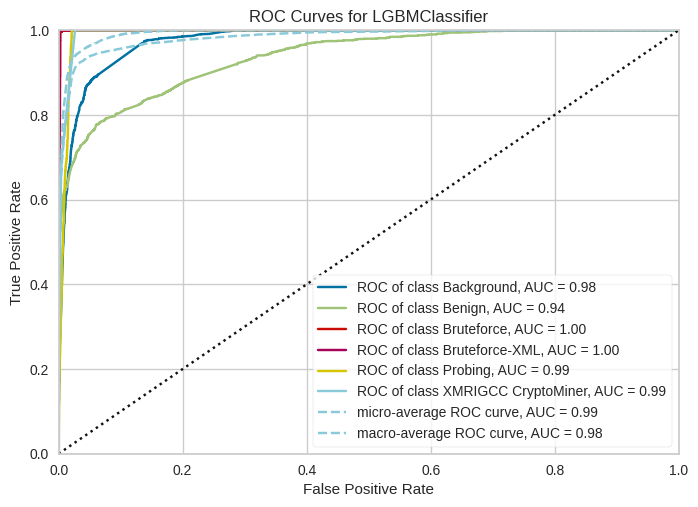

<Axes: title={'center': 'ROC Curves for LGBMClassifier'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

In [13]:
from yellowbrick.classifier import ROCAUC
from yellowbrick.contrib.wrapper import wrap

model = wrap(bst)
visualizer = ROCAUC(model)
visualizer.fit(X_train, y_train)
visualizer.score(X_test, y_test)
visualizer.show()

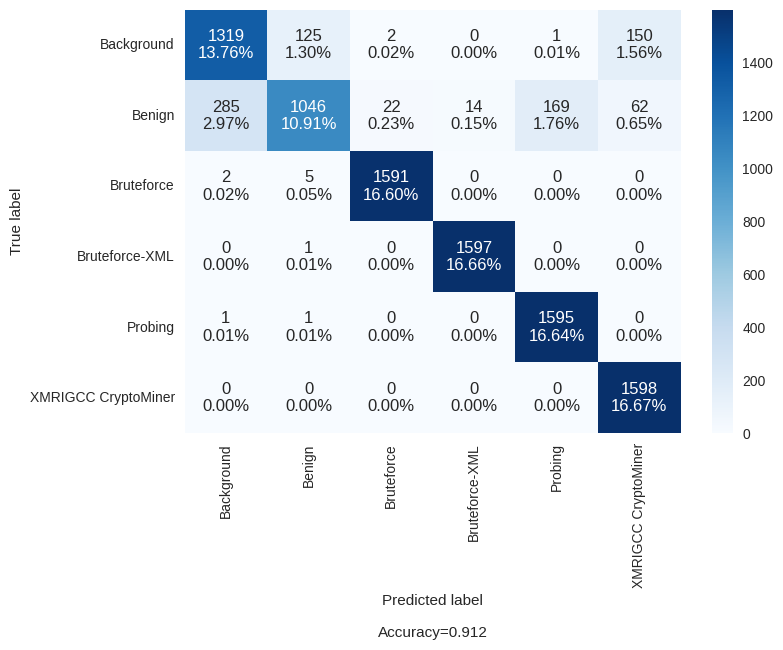

In [14]:
# Show the confusion matrix
cf = metrics.confusion_matrix(y_test,y_predicted_test)
categories = pd.unique(bst.classes_)
make_confusion_matrix(cf, 
                      categories=categories,
                      cmap='Blues')

In [15]:
# Create a plot for each tree in the model
for i in range(bst.n_estimators_):
    graph = lgb.create_tree_digraph(bst, tree_index=i, name='Tree {}'.format(i), show_info=['split_gain', 'internal_value', 'leaf_count'])
    graph.render(filename='tree_{}'.format(i), directory='lgb_data/tree', format='pdf')

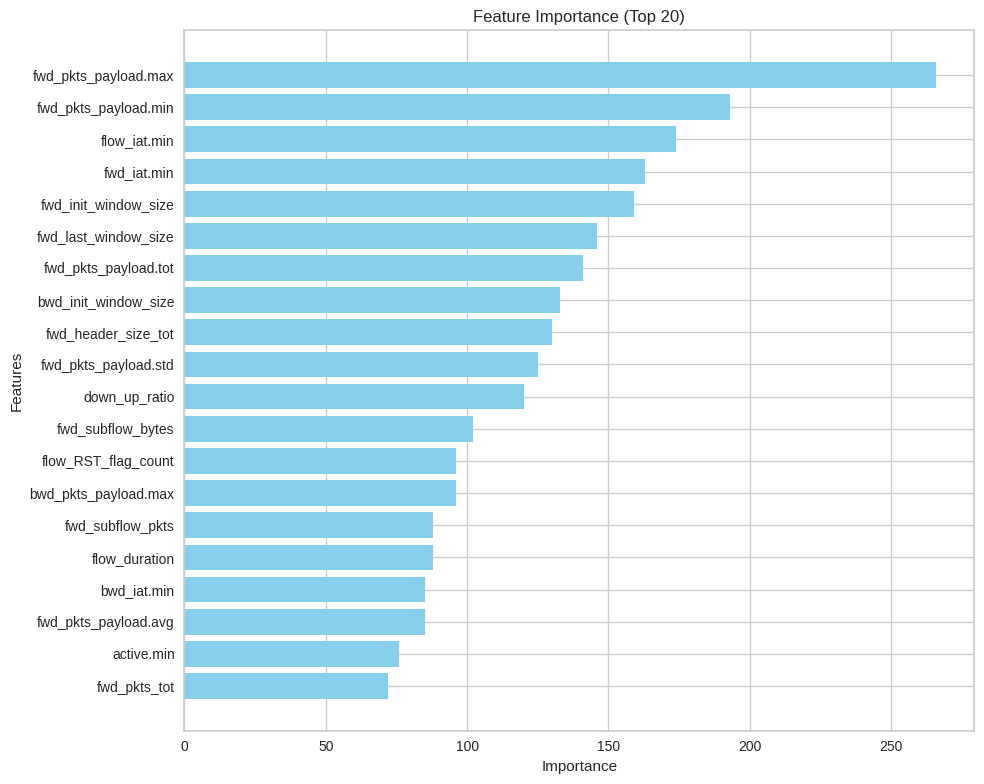

In [16]:
feature_importance = bst.feature_importances_
x_features_np = np.array(x_features)

# Sort indices based on feature importance
sorted_indices = np.argsort(feature_importance)[::-1]
sorted_features = x_features_np[sorted_indices][:20][::-1]  # Select only the first 20 features
sorted_importance = feature_importance[sorted_indices][:20][::-1]  # Select importance values for the first 20 features

# Plotting
plt.figure(figsize=(10, 8))  # Adjust the figure size as needed
plt.barh(range(len(sorted_importance)), sorted_importance, color='skyblue')
plt.yticks(range(len(sorted_importance)), sorted_features)  # Use yticks for feature names
plt.ylabel('Features')
plt.xlabel('Importance')
plt.title('Feature Importance (Top 20)')
plt.tight_layout()

# Show plot
plt.show()

In [17]:
%%time

if False:
    explainer = fasttreeshap.TreeExplainer(bst, X_train, algorithm='auto', n_jobs=-1, feature_perturbation="interventional")
    sv = explainer(X_train, check_additivity=False)

    with open('lgb_data/exp.pickle', 'wb') as handle:
        pickle.dump(sv, handle, protocol=pickle.HIGHEST_PROTOCOL)
else:
    print("loading exp")
    with open('lgb_data/exp.pickle', 'rb') as handle:
        sv = pickle.load(handle)

loading exp
CPU times: user 1.26 ms, sys: 70.4 ms, total: 71.6 ms
Wall time: 69.9 ms


## Background shap

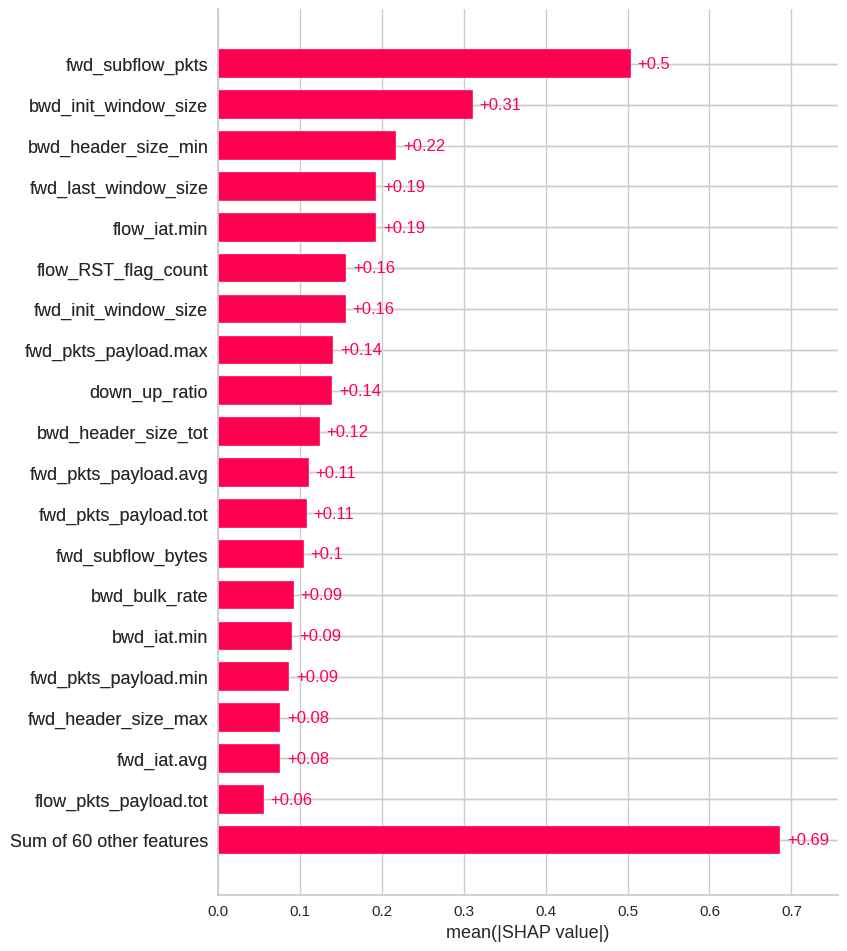

In [18]:
exp = Explanation(sv.values[:,:,0], 
                  sv.base_values[:,0], 
                  data=X_train, 
                  feature_names=x_features)

plots.bar(exp, max_display=20, show=False)
# plt.savefig('tree/shap', dpi=1400, format='pdf', pad_inches=10)
plt.show()

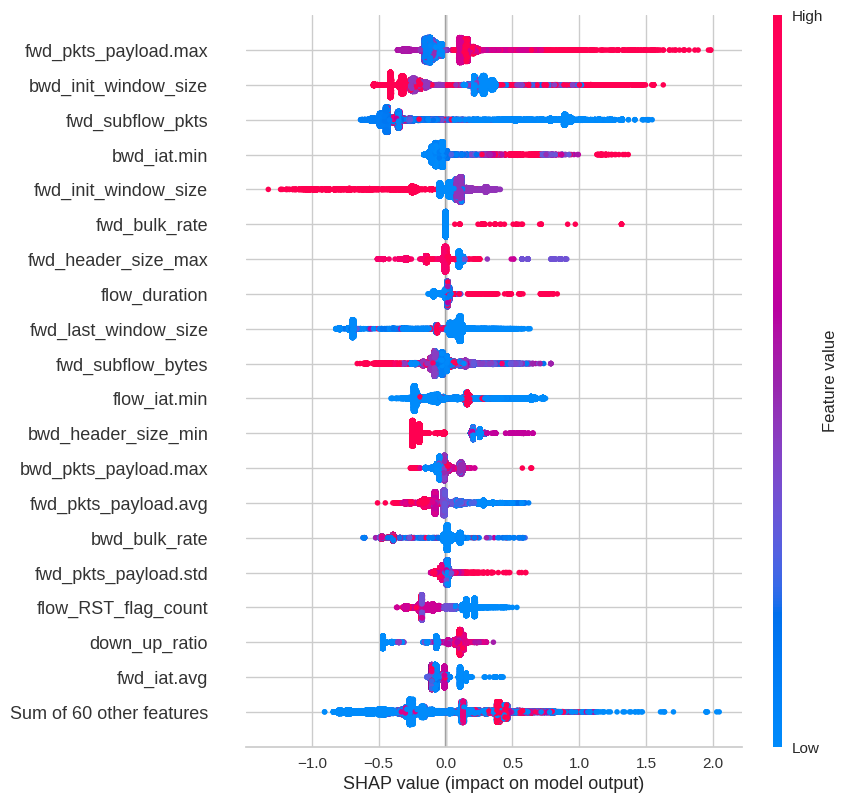

In [19]:
plots.beeswarm(exp,order=exp.abs.max(0),max_display=20)

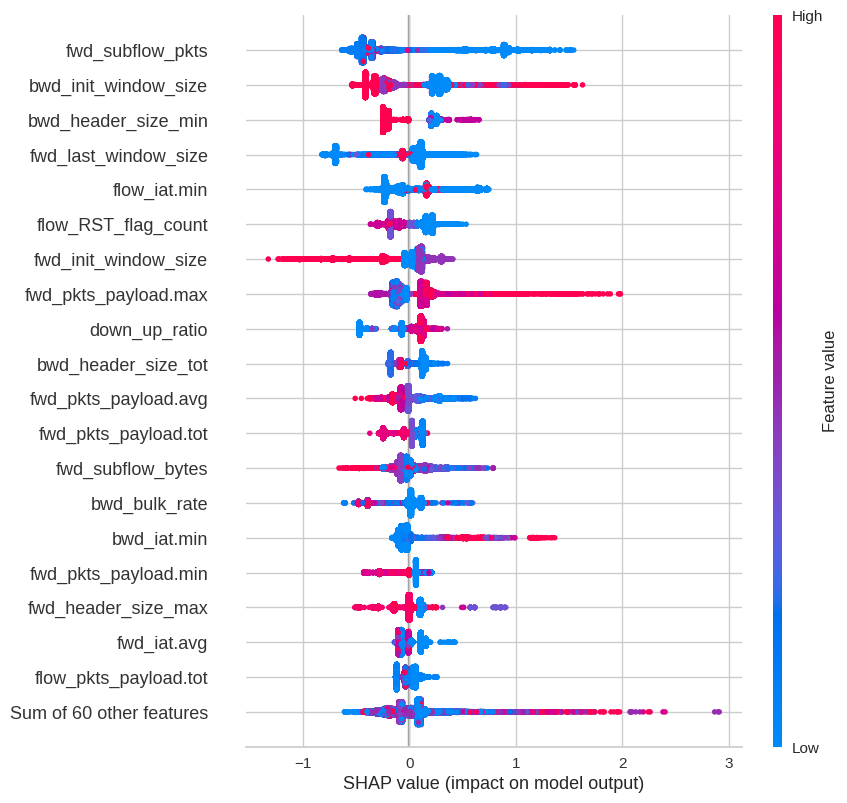

In [20]:
plots.beeswarm(exp,order=exp.abs.mean(0),max_display=20)

## Bening shap

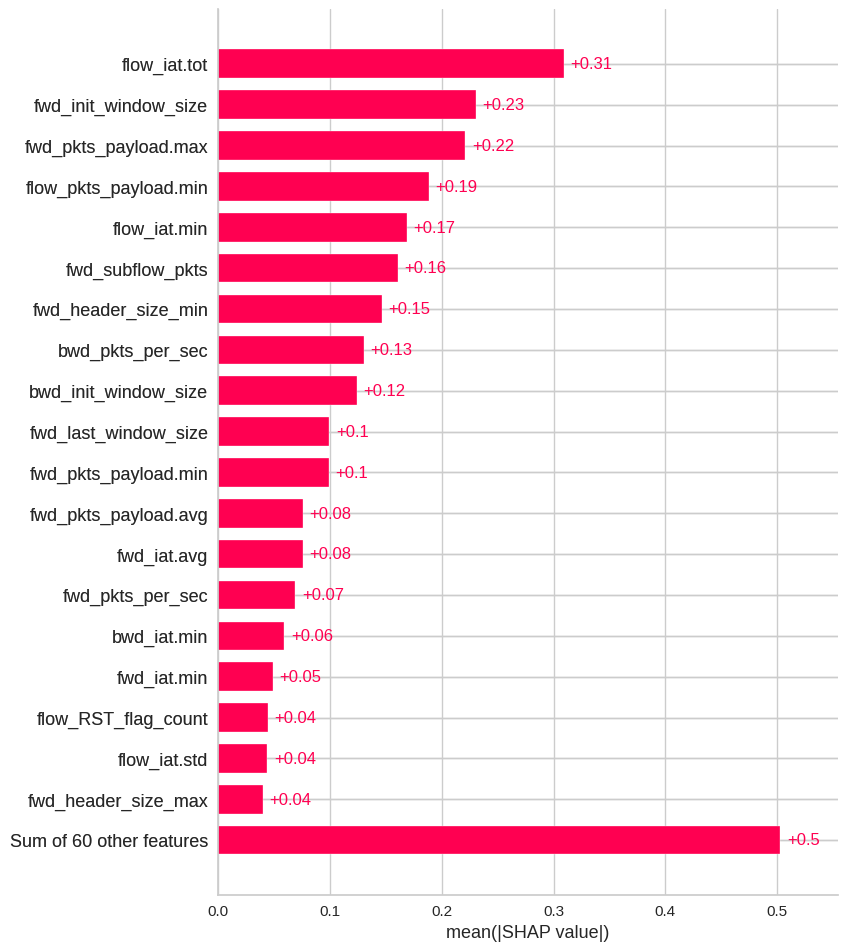

In [22]:
exp = Explanation(sv.values[:,:,1], 
                  sv.base_values[:,1], 
                  data=X_train, 
                  feature_names=x_features)

plots.bar(exp, max_display=20, show=False)
# plt.savefig('tree/shap', dpi=1400, format='pdf', pad_inches=10)
plt.show()

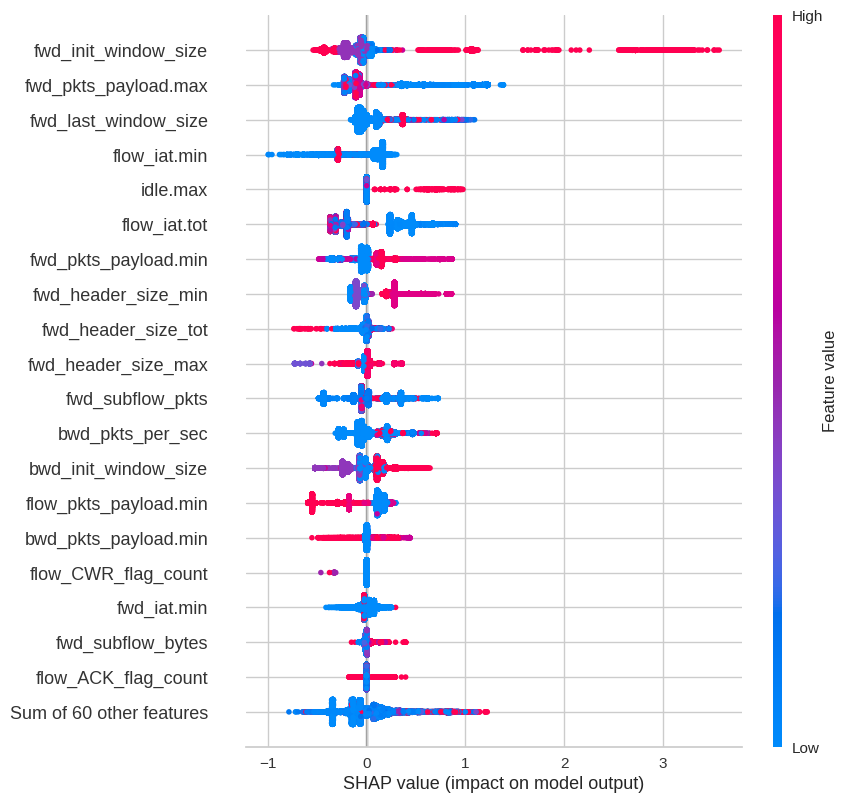

In [23]:
plots.beeswarm(exp,order=exp.abs.max(0),max_display=20)

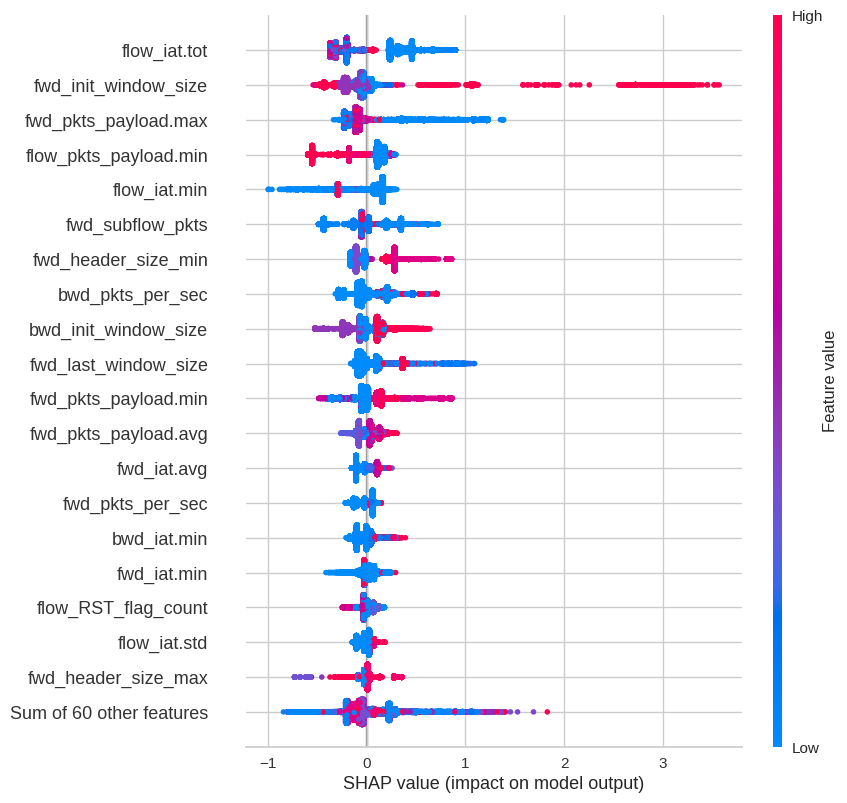

In [24]:
plots.beeswarm(exp,order=exp.abs.mean(0),max_display=20)

## Bruteforce shap

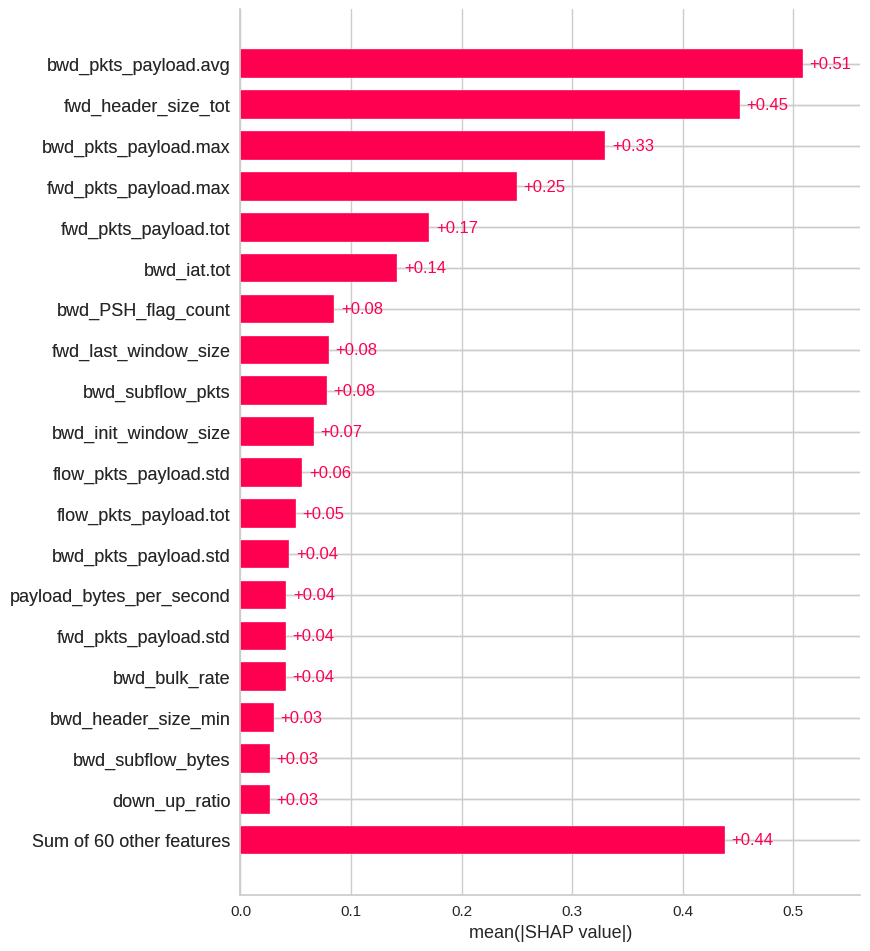

In [25]:
exp = Explanation(sv.values[:,:,2], 
                  sv.base_values[:,2], 
                  data=X_train, 
                  feature_names=x_features)

plots.bar(exp, max_display=20, show=False)
# plt.savefig('tree/shap', dpi=1400, format='pdf', pad_inches=10)
plt.show()

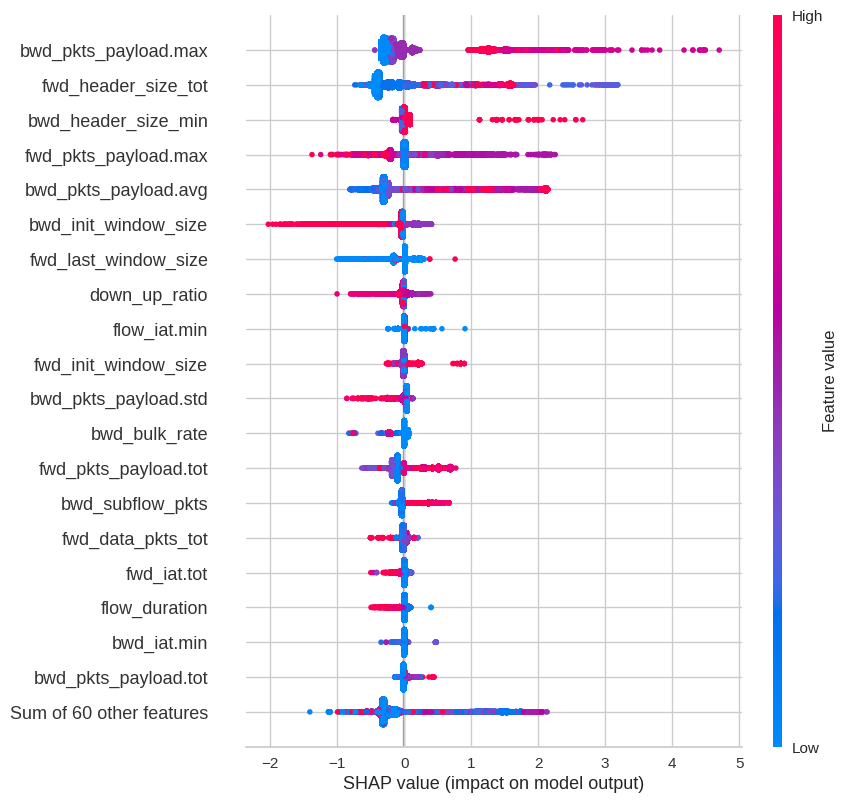

In [26]:
plots.beeswarm(exp,order=exp.abs.max(0),max_display=20)

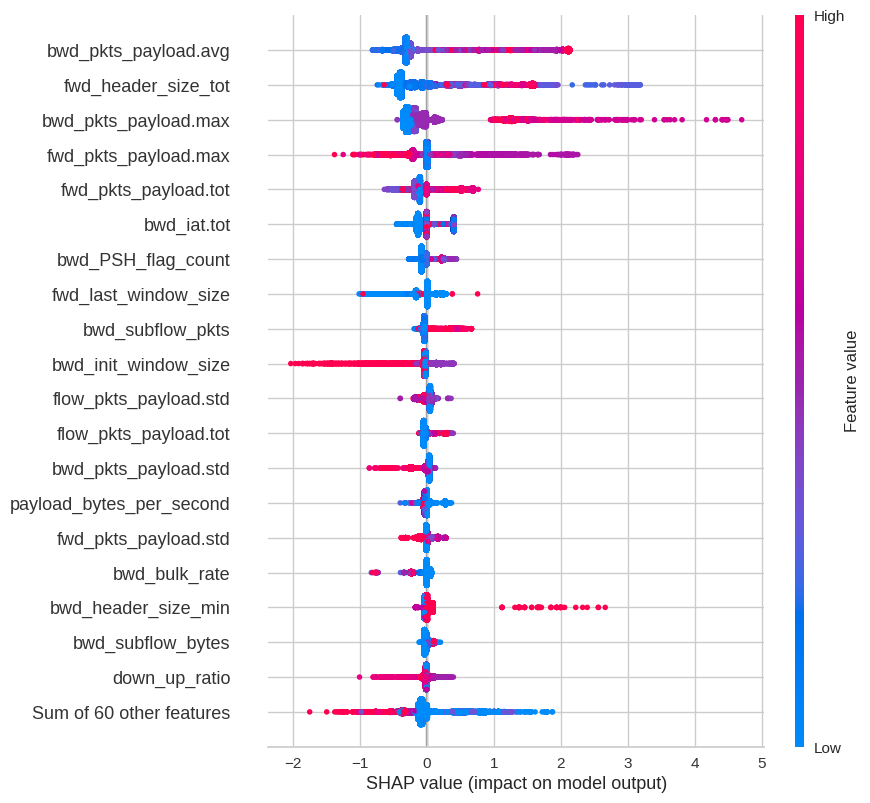

In [27]:
plots.beeswarm(exp,order=exp.abs.mean(0),max_display=20)

## Bruteforce XML shap

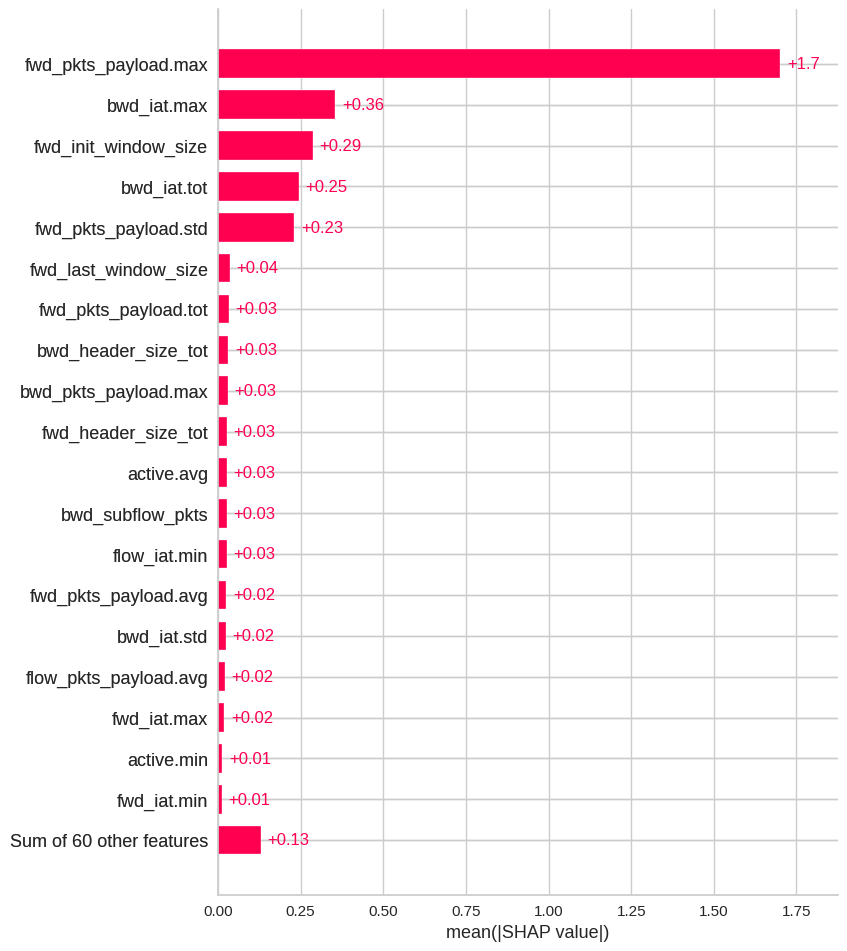

In [28]:
exp = Explanation(sv.values[:,:,3], 
                  sv.base_values[:,3], 
                  data=X_train, 
                  feature_names=x_features)

plots.bar(exp, max_display=20, show=False)
# plt.savefig('tree/shap', dpi=1400, format='pdf', pad_inches=10)
plt.show()

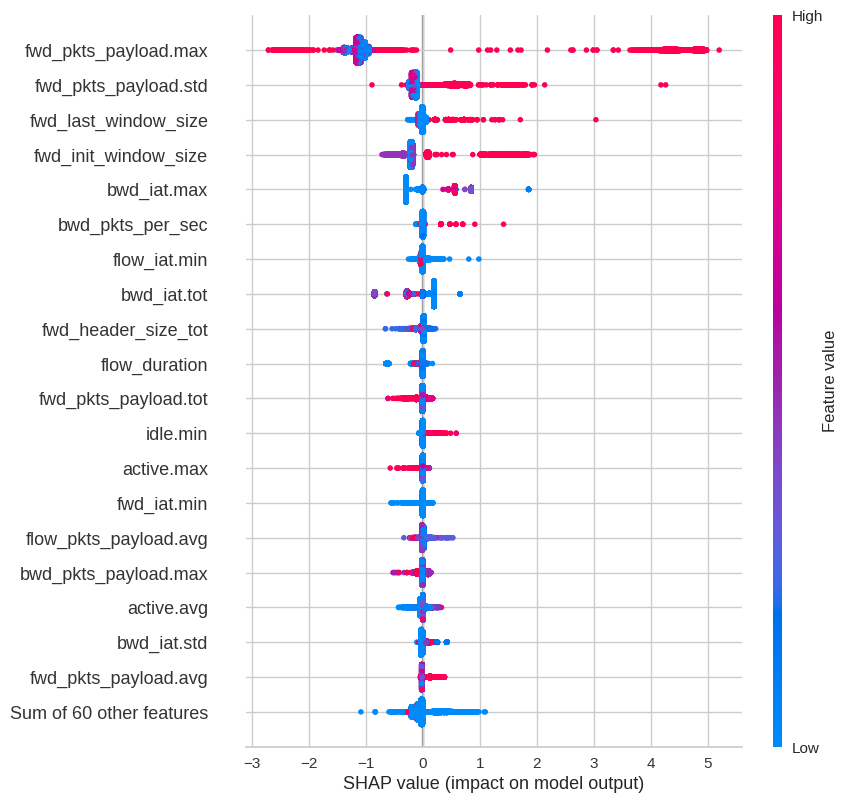

In [29]:
plots.beeswarm(exp,order=exp.abs.max(0),max_display=20)

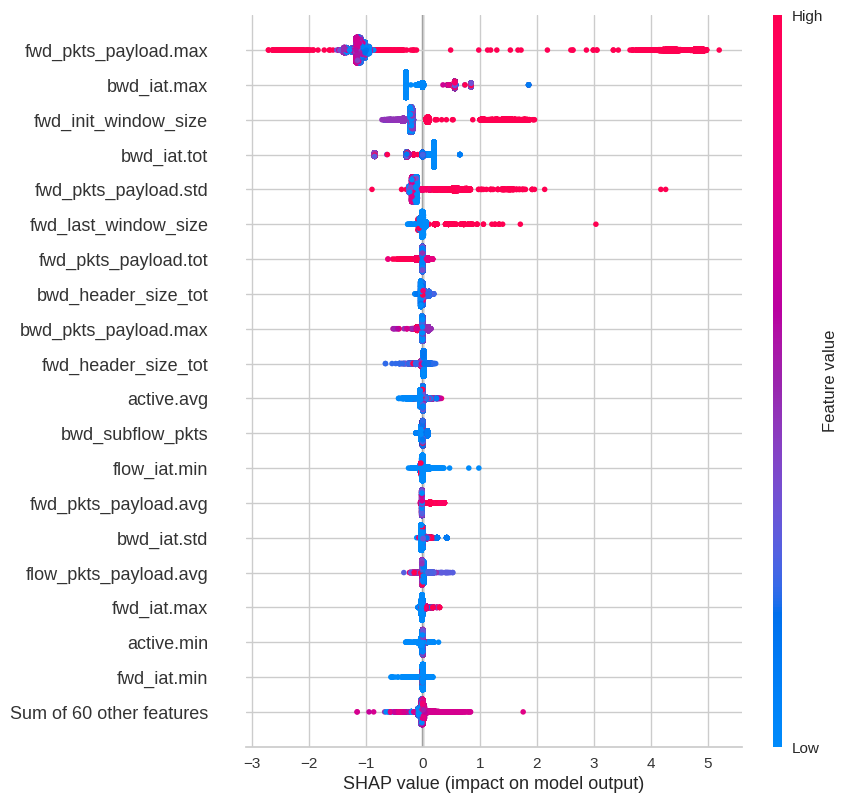

In [30]:
plots.beeswarm(exp,order=exp.abs.mean(0),max_display=20)

## Probing shap

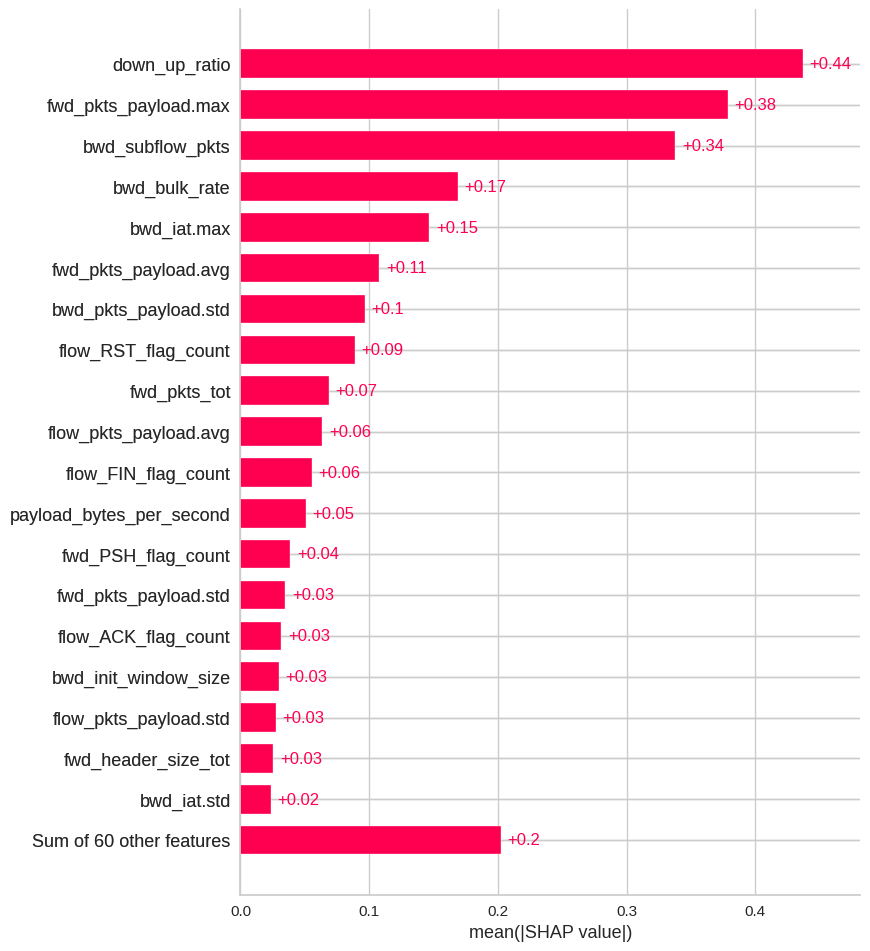

In [31]:
exp = Explanation(sv.values[:,:,4], 
                  sv.base_values[:,4], 
                  data=X_train, 
                  feature_names=x_features)

plots.bar(exp, max_display=20, show=False)
# plt.savefig('tree/shap', dpi=1400, format='pdf', pad_inches=10)
plt.show()

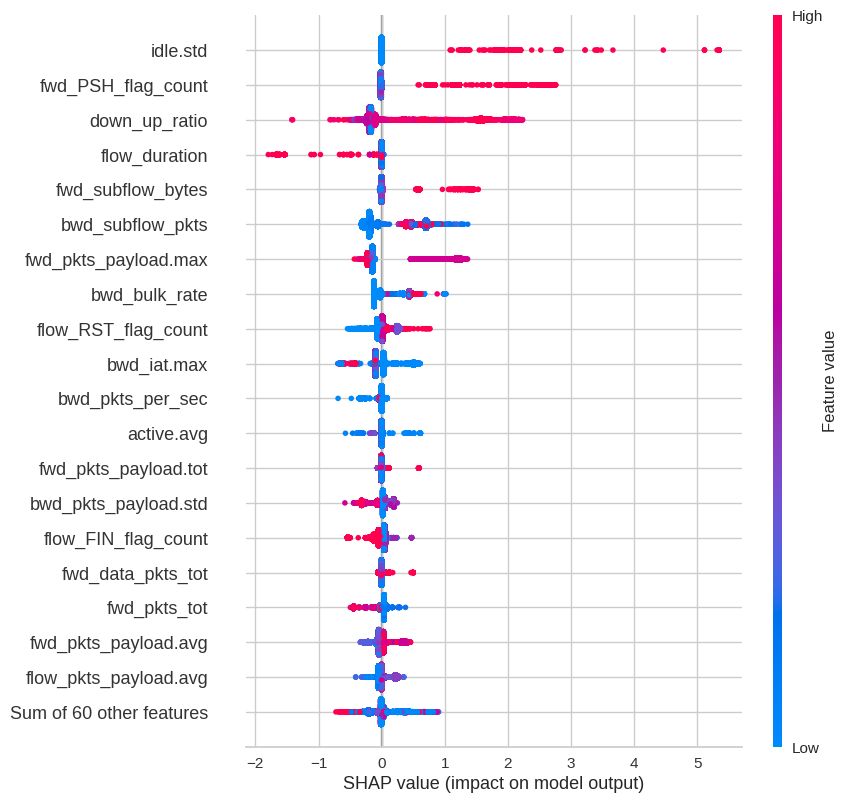

In [32]:
plots.beeswarm(exp,order=exp.abs.max(0),max_display=20)

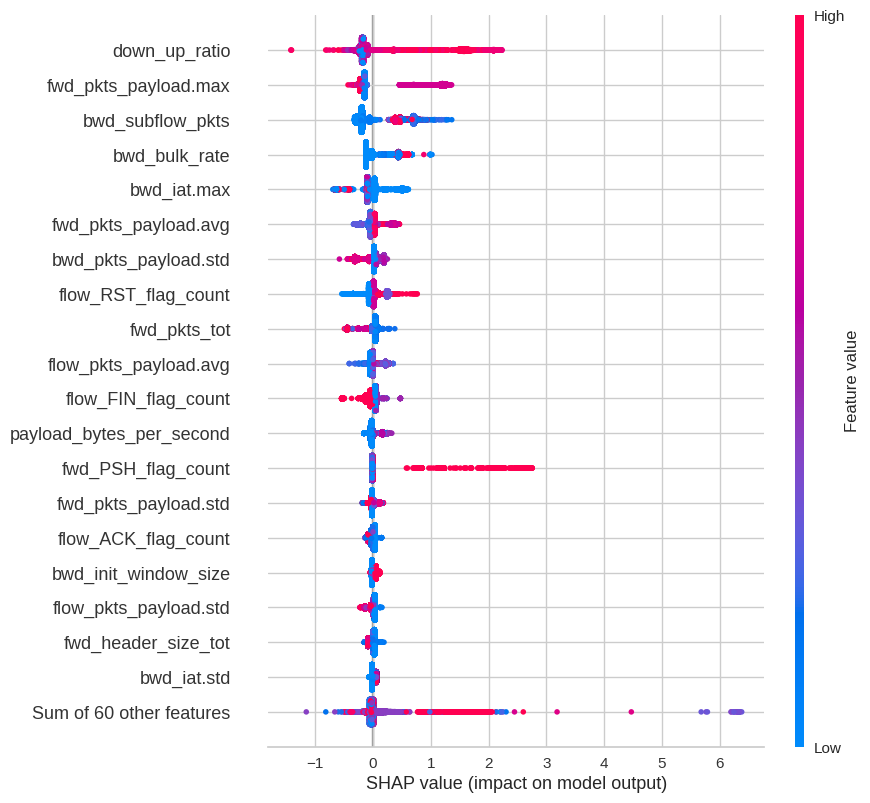

In [33]:
plots.beeswarm(exp,order=exp.abs.mean(0),max_display=20)

## Miner shap

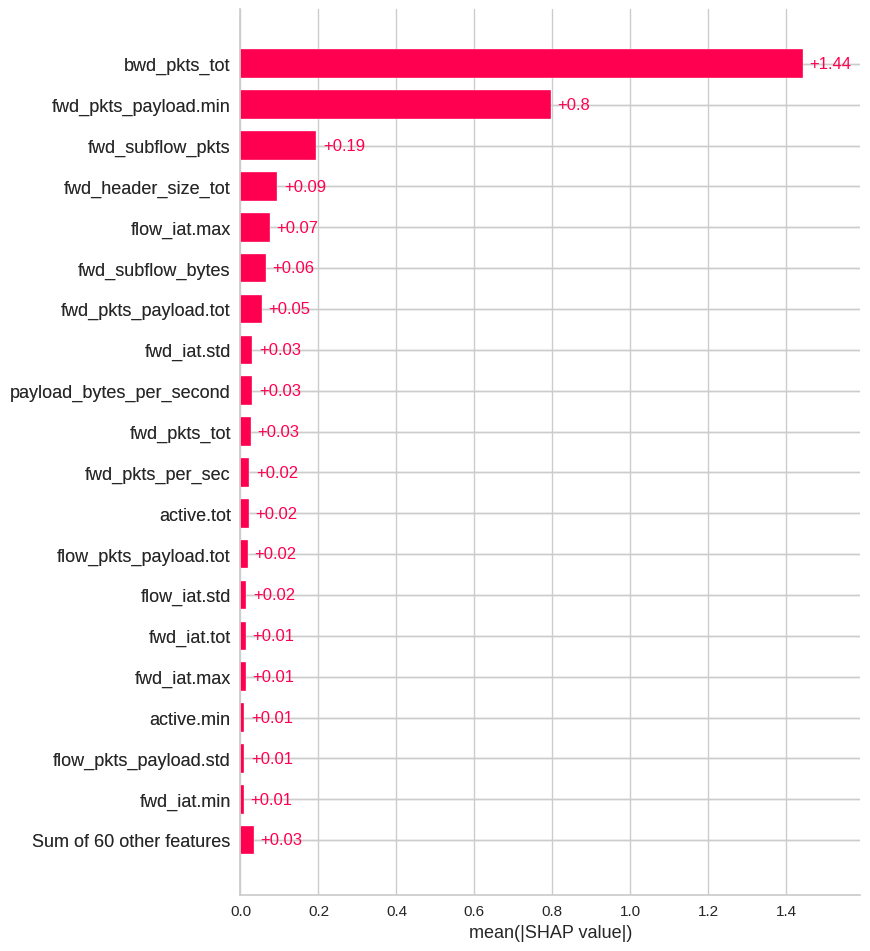

In [34]:
exp = Explanation(sv.values[:,:,5], 
                  sv.base_values[:,5], 
                  data=X_train, 
                  feature_names=x_features)

plots.bar(exp, max_display=20, show=False)
# plt.savefig('tree/shap', dpi=1400, format='pdf', pad_inches=10)
plt.show()

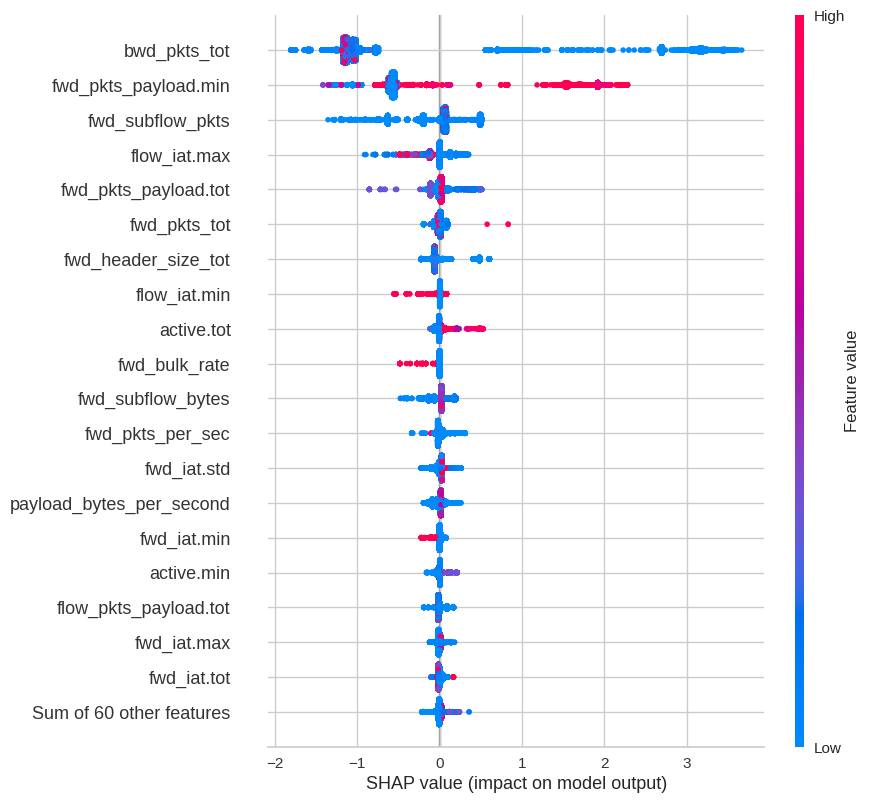

In [35]:
plots.beeswarm(exp,order=exp.abs.max(0),max_display=20)

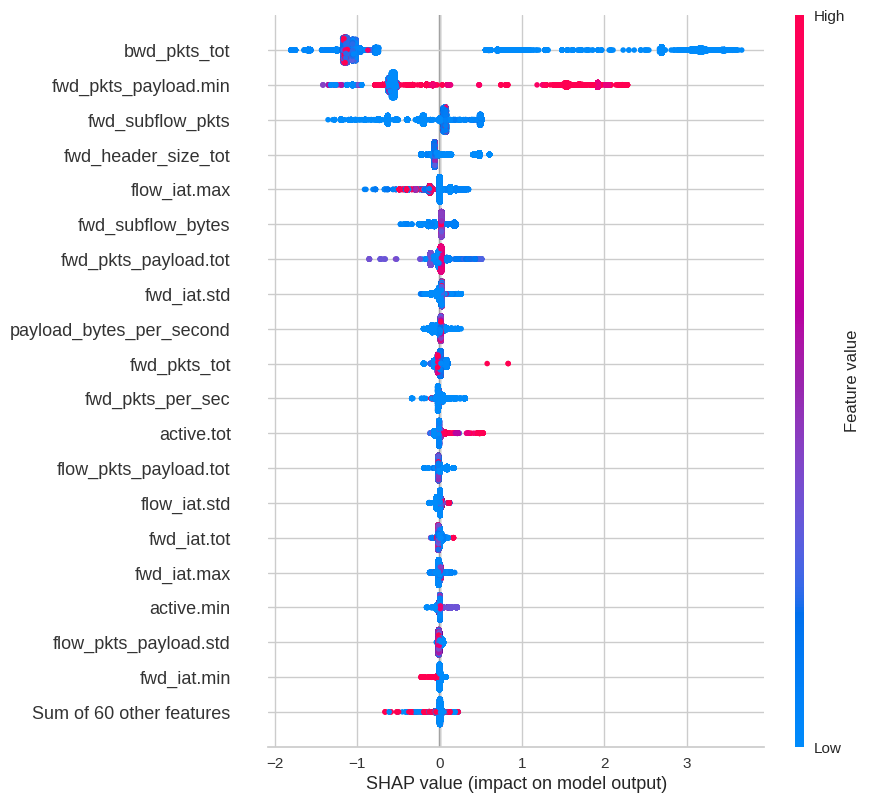

In [36]:
plots.beeswarm(exp,order=exp.abs.mean(0),max_display=20)

In [23]:
pv.feature_importance = pd.DataFrame(data={'importance' : exp.abs.mean(0).values, 'feature': x_features})
pv.feature_importance.sort_values('importance',ascending=False).head(20)

,importance,feature
26,0.889925,fwd_pkts_payload.max
58,0.611799,fwd_subflow_bytes
3,0.477658,fwd_data_pkts_tot
0,0.443603,flow_duration
15,0.405274,flow_FIN_flag_count
27,0.397459,fwd_pkts_payload.tot
78,0.261660,fwd_last_window_size
30,0.239678,bwd_pkts_payload.min
77,0.209117,bwd_init_window_size
45,0.202534,bwd_iat.min


In [24]:
pv.feature_above_zero = pv.feature_importance.query('importance > 0').sort_values('importance',ascending=False)['feature'].to_list()

In [25]:
%%time

if True:
    result = pv.recursive_reduction()
    feature_reduction_scores = pd.DataFrame({'F1_score': result[0], 'score_std': result[1], 'n_features': result[2], 'cv_time': result[3]})
    
    with open('lgb_data/feature_reduction_scores.pickle', 'wb') as handle:
        pickle.dump(feature_reduction_scores, handle, protocol=pickle.HIGHEST_PROTOCOL)
else:
    with open('lgb_data/feature_reduction_scores.pickle', 'rb') as handle:
        feature_reduction_scores = pickle.load(handle)

Running the cross validation
testing with 62 features
Running the cross validation
testing with 61 features
Running the cross validation
testing with 60 features
Running the cross validation
testing with 59 features
Running the cross validation
testing with 58 features
Running the cross validation
testing with 57 features
Running the cross validation
testing with 56 features
Running the cross validation
testing with 55 features
Running the cross validation
testing with 54 features
Running the cross validation
testing with 53 features
Running the cross validation
testing with 52 features
Running the cross validation
testing with 51 features
Running the cross validation
testing with 50 features
Running the cross validation
testing with 49 features
Running the cross validation
testing with 48 features
Running the cross validation
testing with 47 features
Running the cross validation
testing with 46 features
Running the cross validation
testing with 45 features
Running the cross validation

<Axes: xlabel='n_features', ylabel='cv_time'>

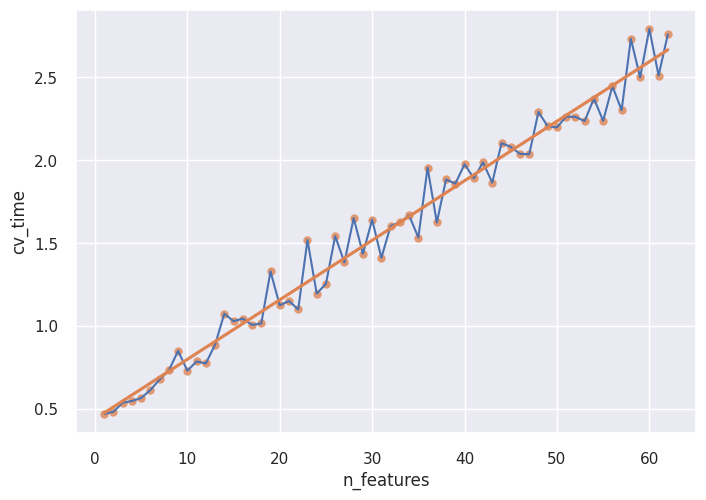

In [26]:
sns.set_theme()
sns.lineplot(data=feature_reduction_scores, x="n_features", y="cv_time")
sns.regplot(data=feature_reduction_scores, x="n_features", y="cv_time", ci=None)  # ci=None removes confidence intervals

<Axes: xlabel='n_features', ylabel='F1_score'>

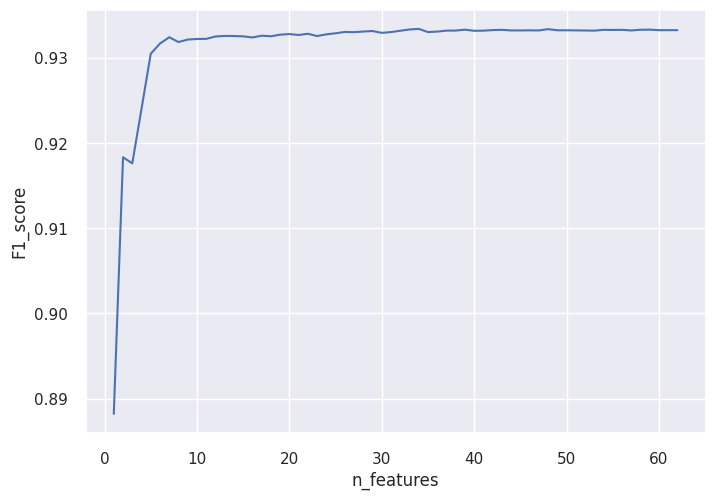

In [27]:
sns.set_theme()
sns.lineplot(data=feature_reduction_scores, x="n_features", y="F1_score")

<Axes: xlabel='n_features', ylabel='score_std'>

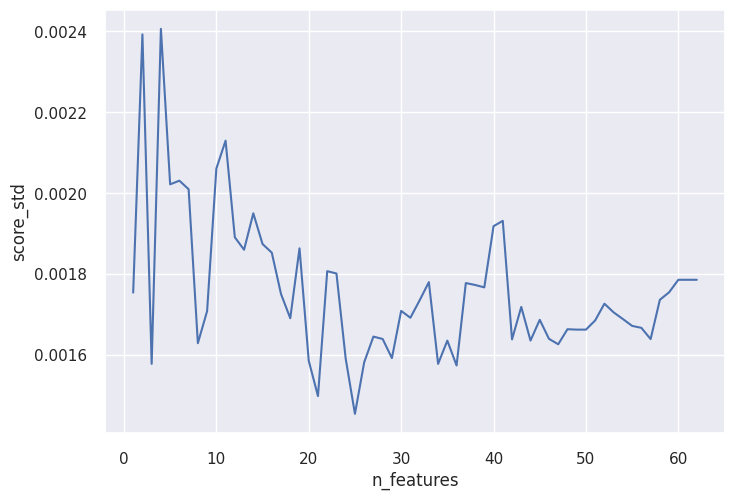

In [28]:
sns.set_theme()
sns.lineplot(data=feature_reduction_scores, x="n_features", y="score_std")

In [29]:
feature_reduction_scores.sort_values('F1_score', ascending=False)

,F1_score,score_std,n_features,cv_time
28,0.933414,0.001578,34,1.668516
14,0.933381,0.001664,48,2.292057
29,0.933343,0.001780,33,1.625744
3,0.933325,0.001755,59,2.500482
23,0.933321,0.001767,39,1.859511
...,...,...,...,...
57,0.930499,0.002022,5,0.566058
58,0.924026,0.002406,4,0.548098
60,0.918343,0.002392,2,0.482622
59,0.917628,0.001578,3,0.538037


In [30]:
%%time

if True:
    zero_day_feature_reduction_scores = pv.run_zero_day_test()
    with open('lgb_data/zero_day_feature_reduction_scores.pickle', 'wb') as handle:
        pickle.dump(zero_day_feature_reduction_scores, handle, protocol=pickle.HIGHEST_PROTOCOL)
else:
    with open('lgb_data/zero_day_feature_reduction_scores.pickle', 'rb') as handle:
        zero_day_feature_reduction_scores = pickle.load(handle)

traing for  XMRIGCC CryptoMiner
training with 62 features
Running the stratified 5-fold
Test and Train k-fold created
Running the cross validation
training with 61 features
Running the cross validation
training with 60 features
Running the cross validation
training with 59 features
Running the cross validation
training with 58 features
Running the cross validation
training with 57 features
Running the cross validation
training with 56 features
Running the cross validation
training with 55 features
Running the cross validation
training with 54 features
Running the cross validation
training with 53 features
Running the cross validation
training with 52 features
Running the cross validation
training with 51 features
Running the cross validation
training with 50 features
Running the cross validation
training with 49 features
Running the cross validation
training with 48 features
Running the cross validation
training with 47 features
Running the cross validation
training with 46 features
Ru

In [31]:
# here I create this detected variable, so that we can see how many attacks are detected because only by using the mean we didn't get the best one
zero_day_feature_reduction_scores['detected'] = np.where(zero_day_feature_reduction_scores['attack_recall'] > 0, 1, 0)

In [32]:
zero_day_feature_reduction_scores.query('attack_recall != 0').sort_values('attack_recall', ascending=False)

,attack_f1,attack_recall,attack_precision,cv_score_avg,cv_score_std,n_features,attack_name,fit_time,pred_time,detected
223,0.031131,0.017902,0.119266,0.936209,0.003479,25,Bruteforce-XML,0.186584,0.008430,1
225,0.031128,0.017902,0.119167,0.936030,0.003620,23,Bruteforce-XML,0.464357,0.008263,1
144,0.028830,0.016525,0.112917,0.937637,0.004265,42,Bruteforce,0.271629,0.008929,1
145,0.028830,0.016525,0.112917,0.937637,0.004265,41,Bruteforce,0.296489,0.010724,1
146,0.028830,0.016525,0.112917,0.937637,0.004265,40,Bruteforce,0.285452,0.010016,1
...,...,...,...,...,...,...,...,...,...,...
155,0.000222,0.000125,0.000964,0.937677,0.004369,31,Bruteforce,0.283746,0.006779,1
156,0.000222,0.000125,0.000964,0.937622,0.004422,30,Bruteforce,0.195951,0.006882,1
157,0.000222,0.000125,0.000964,0.937615,0.004429,29,Bruteforce,0.271036,0.014154,1
158,0.000222,0.000125,0.000964,0.937622,0.004422,28,Bruteforce,0.482992,0.011827,1


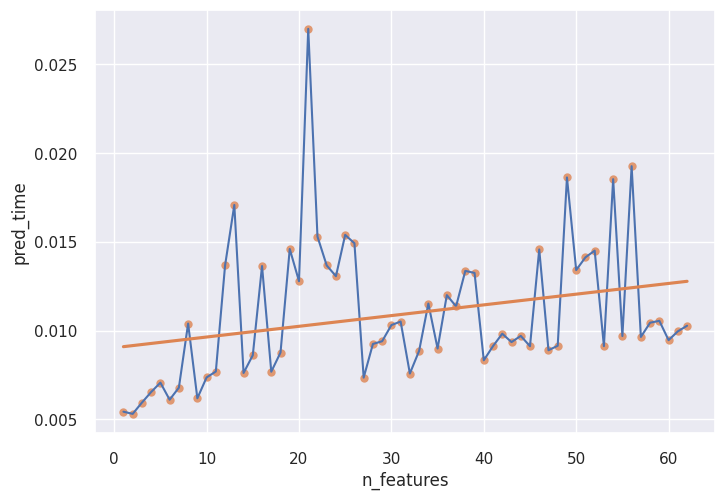

In [33]:
def print_plot():
    data = zero_day_feature_reduction_scores.groupby('n_features')[['pred_time','n_features']].mean().query('n_features < 79')
    sns.set_theme()
    sns.lineplot(data=data, x=data.index, y='pred_time')
    sns.regplot(data=data, x="n_features", y="pred_time", ci=None)  # ci=None removes confidence intervals

print_plot()

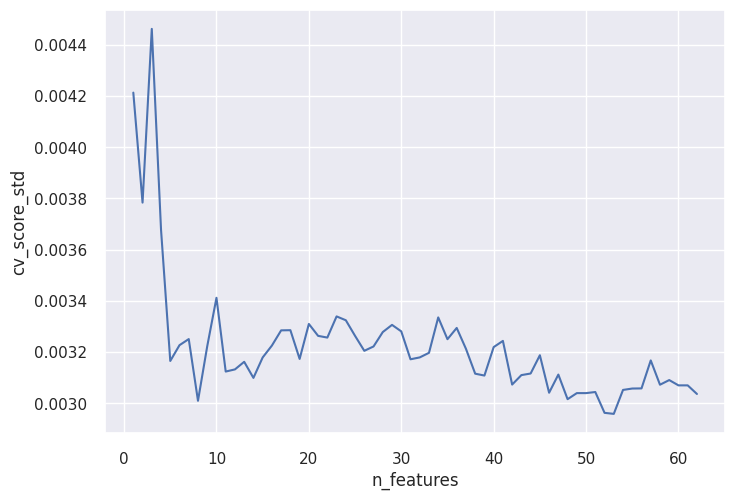

In [34]:
def print_plot():
    data = zero_day_feature_reduction_scores.groupby('n_features')[['cv_score_std','n_features']].mean().query('n_features < 79')
    sns.set_theme()
    sns.lineplot(data=data, x=data.index, y='cv_score_std')

print_plot()

In [35]:
zero_day_feature_reduction_scores.groupby('n_features')[['attack_f1','attack_recall','attack_precision','cv_score_avg','cv_score_std','fit_time','pred_time', 'detected']].mean().sort_values(['attack_recall', 'attack_precision'], ascending=False)

,attack_f1,attack_recall,attack_precision,cv_score_avg,cv_score_std,fit_time,pred_time,detected
n_features,,,,,,,,
23,0.009213,0.005258,0.038343,0.949668,0.003339,0.358987,0.013673,0.75
25,0.008749,0.005008,0.035310,0.949570,0.003263,0.221508,0.015395,0.75
40,0.008413,0.004788,0.035627,0.949834,0.003220,0.315482,0.008329,0.75
41,0.008413,0.004788,0.035627,0.949833,0.003244,0.292934,0.009129,0.75
42,0.008413,0.004788,0.035599,0.949804,0.003073,0.342261,0.009826,0.75
...,...,...,...,...,...,...,...,...
2,0.000000,0.000000,0.000000,0.933788,0.003783,0.082147,0.005310,0.00
3,0.000000,0.000000,0.000000,0.935243,0.004461,0.095316,0.005944,0.00
4,0.000000,0.000000,0.000000,0.943614,0.003678,0.084518,0.006541,0.00


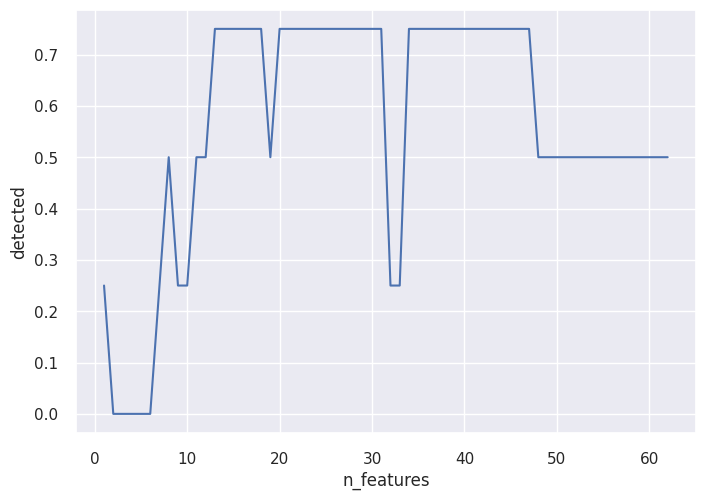

In [36]:
def print_plot():
    data = zero_day_feature_reduction_scores.groupby('n_features')[['detected','n_features']].mean().query('n_features < 79')
    sns.set_theme()
    sns.lineplot(data=data, x=data.index, y='detected')

print_plot()

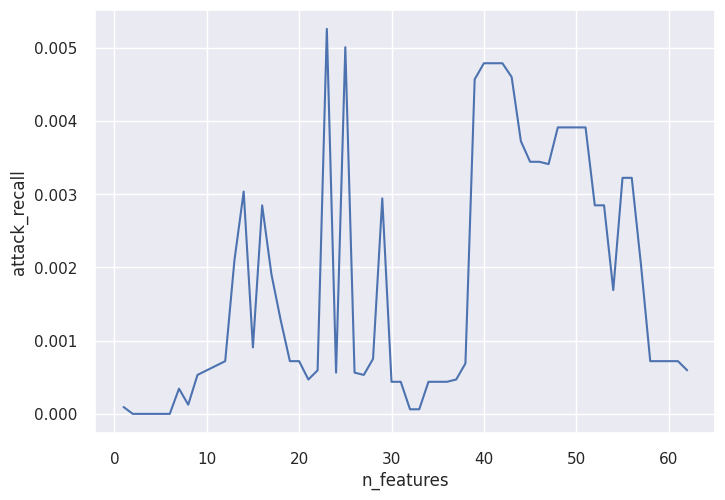

In [37]:
def print_plot():
    data = zero_day_feature_reduction_scores.groupby('n_features')[['attack_recall','n_features']].mean().query('n_features < 79')
    sns.set_theme()
    sns.lineplot(data=data, x=data.index, y='attack_recall')

print_plot()

In [38]:
zero_day_feature_reduction_scores.groupby('n_features')[['attack_f1','attack_recall','attack_precision','cv_score_avg','cv_score_std','fit_time','pred_time']].mean().sort_values('attack_f1', ascending=False)

,attack_f1,attack_recall,attack_precision,cv_score_avg,cv_score_std,fit_time,pred_time
n_features,,,,,,,
23,0.009213,0.005258,0.038343,0.949668,0.003339,0.358987,0.013673
25,0.008749,0.005008,0.035310,0.949570,0.003263,0.221508,0.015395
40,0.008413,0.004788,0.035627,0.949834,0.003220,0.315482,0.008329
41,0.008413,0.004788,0.035627,0.949833,0.003244,0.292934,0.009129
42,0.008413,0.004788,0.035599,0.949804,0.003073,0.342261,0.009826
...,...,...,...,...,...,...,...
2,0.000000,0.000000,0.000000,0.933788,0.003783,0.082147,0.005310
6,0.000000,0.000000,0.000000,0.947834,0.003227,0.096537,0.006108
5,0.000000,0.000000,0.000000,0.947462,0.003165,0.118280,0.007069


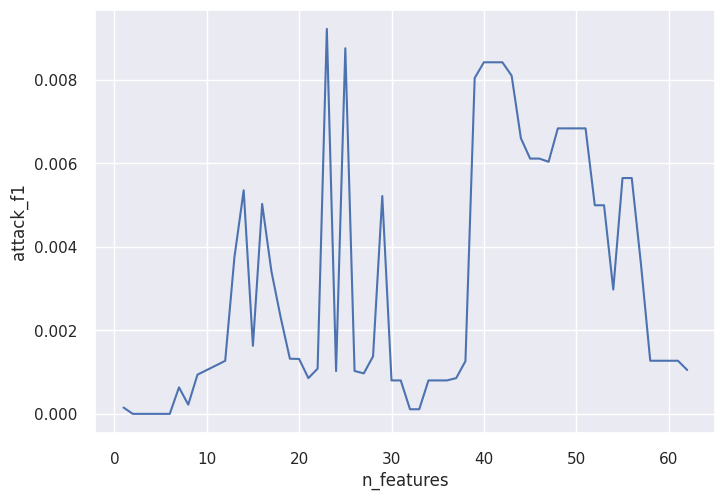

In [39]:
def print_plot():
    data = zero_day_feature_reduction_scores.groupby('n_features')[['attack_f1','n_features']].mean().query('n_features < 79')
    sns.set_theme()
    sns.lineplot(data=data, x=data.index, y='attack_f1')

print_plot()

In [40]:
zero_day_feature_reduction_scores.query('n_features == 2')

,attack_f1,attack_recall,attack_precision,cv_score_avg,cv_score_std,n_features,attack_name,fit_time,pred_time,detected
60,0.0,0.0,0.0,0.950944,0.003859,2,XMRIGCC CryptoMiner,0.084059,0.004525,0
122,0.0,0.0,0.0,0.953105,0.004264,2,Probing,0.085080,0.005229,0
184,0.0,0.0,0.0,0.917936,0.004422,2,Bruteforce,0.080558,0.005925,0
246,0.0,0.0,0.0,0.913165,0.002589,2,Bruteforce-XML,0.078891,0.005559,0
